In [1]:
import pandas as pd
import numpy as np
import json

In [2]:
from pathlib import Path
from glob import glob

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from torch import optim

In [4]:
from data_loader import DatasetLoader
# from custom_data import PrivacyDataset

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
annotation_path='data/val/val_annotations'
img_path='data/val/val_images'

In [7]:
# Loading data with labels
loader = DatasetLoader()
loaded_data = loader.load_data(annotation_path)

ValueError: No objects to concatenate

In [8]:
# check for appropriate number of data points
assert(len(loaded_data.index)==4167)

NameError: name 'loaded_data' is not defined

In [9]:
# Visualise data with each label as column an binary encoding
loaded_data.head()

NameError: name 'loaded_data' is not defined

#### **Dataset subsection**

In [26]:
loaded_data = loaded_data[:100]

#### **Training Preparation**

In [27]:
train_size=round(len(loaded_data) * 0.8)
val_size=round(len(loaded_data) * 0.2)
train_size + val_size

100

In [28]:
# Define relevant transformations inc. converting images to tensors
transform = transforms.Compose([transforms.ToPILImage(),
                                transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))
                                ])

In [29]:
dataset=PrivacyDataset(path=img_path,loaded_data=loaded_data,transform=transform)

In [30]:
train_set, val_set = torch.utils.data.random_split(dataset,[train_size,val_size])

In [31]:
train_loader=DataLoader(dataset=train_set,batch_size=2,shuffle=True)
val_loader=DataLoader(dataset=val_set,batch_size=2,shuffle=True)

#### **Testing output of custom dataset**

In [32]:
img, label = next(iter(train_loader))

In [33]:
img.shape
img[0].shape
img[0].size()[0]
new_img = img[0]
new_img.shape

torch.Size([3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


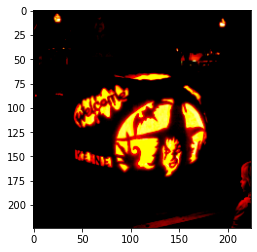

In [34]:
import matplotlib.pyplot as plt
plt.imshow(img[0].permute(1, 2, 0)); # requires channel dimension to be indexed last

In [35]:
label.shape

torch.Size([2, 68])

In [36]:
# TODO: function to convert tensor to class activations
attr=loader.get_attr()
attr

Index(['a0_safe', 'a17_color', 'a6_hair_color', 'a16_race', 'a1_age_approx',
       'a24_birth_date', 'a29_ausweis', 'a2_weight_approx', 'a3_height_approx',
       'a4_gender', 'a5_eye_color', 'a78_address_home_complete',
       'a82_date_time', 'a9_face_complete', 'a18_ethnic_clothing',
       'a55_religion', 'a65_rel_social', 'a10_face_partial',
       'a61_opinion_general', 'a69_rel_views', 'a12_semi_nudity',
       'a64_rel_personal', 'a48_occassion_work', 'a66_rel_professional',
       'a60_occassion_personal', 'a46_occupation', 'a73_landmark',
       'a19_name_full', 'a25_nationality', 'a74_address_current_complete',
       'a8_signature', 'a41_injury', 'a103_license_plate_complete',
       'a26_handwriting', 'a75_address_current_partial', 'a49_phone',
       'a37_receipt', 'a70_education_history', 'a57_culture',
       'a68_rel_spectators', 'a23_birth_city', 'a99_legal_involvement',
       'a59_sports', 'a67_rel_competitors', 'a39_disability_physical',
       'a43_medicine', 'a1

#### **Sample training loop**

In [37]:
# Transfer learning, fine-tuning densenet121 
model = models.densenet121(pretrained=True)

In [38]:
for param in model.parameters():
    param.requires_grad = False

from collections import OrderedDict
classifier = nn.Sequential(nn.Linear(1024, 500),
                           nn.ReLU(),
                           nn.Linear(500, 68),
                           nn.Sigmoid()
                          )
    
model.classifier = classifier

In [39]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=1e-3)

#### **Training on a single datapoint**

In [40]:
inputs, labels = next(iter(train_loader))

# Training loop

model.train()

optimizer.zero_grad()
output = model.forward(inputs)
loss = criterion(output, labels)
loss.backward()
optimizer.step()

print('Training batch loss:', loss.item())

# Test loop

test_loss = 0
inputs, labels = next(iter(val_loader))

model.eval()

output = model.forward(inputs)
threshold=0.5
equals = label.detach().numpy() == (output.detach().numpy() > threshold)
t_loss = criterion(output, label)
print('Test accuracy:',equals.mean())
print('Test batch loss:', t_loss.item())

Training batch loss: 0.6983542442321777
Test accuracy: 0.7132352941176471
Test batch loss: 0.6289801597595215


#### **Full training loop**

In [42]:
epochs = 5
running_loss = 0
val_loss = 0
accuracy = 0

for epoch in range(epochs):
    for inputs, labels, _ in train_loader:
        
        model.train()
        
        steps += 1        
        optimizer.zero_grad()
        output = model(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
            
    with torch.no_grad():
        for inputs, labels in val_loader:

            model.eval()
            
            output = model(inputs)
            batch_loss = criterion(output, labels)
            val_loss += batch_loss.item()

            # Calculate accuracy
            threshold=0.5
            equals = label.detach().numpy() == (output.detach().numpy() > threshold)
            accuracy += equals.mean()
                    
    print(f"Epoch {epoch+1}/{epochs}.. "
          f"Train loss: {running_loss/len(train_loader):.3f}.. "
          f"Validation loss: {val_loss/len(val_loader):.3f}.. "
          f"Validation accuracy: {accuracy/len(val_loader):.3f}")
    running_loss = 0
    val_loss = 0
    accuracy = 0

Epoch 1/5.. Train loss: 0.199.. Test loss: 0.233.. Test accuracy: 0.915
Epoch 2/5.. Train loss: 0.199.. Test loss: 0.199.. Test accuracy: 0.935
Epoch 3/5.. Train loss: 0.187.. Test loss: 0.195.. Test accuracy: 0.932
Epoch 4/5.. Train loss: 0.188.. Test loss: 0.170.. Test accuracy: 0.946
Epoch 5/5.. Train loss: 0.179.. Test loss: 0.182.. Test accuracy: 0.944
